# In-Depth: Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

As part of our disussion of Bayesian classification (see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)), we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

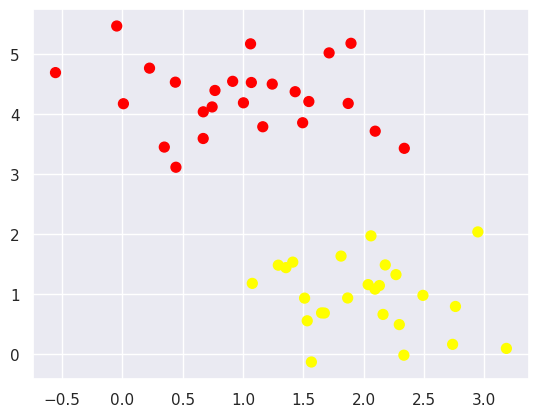

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

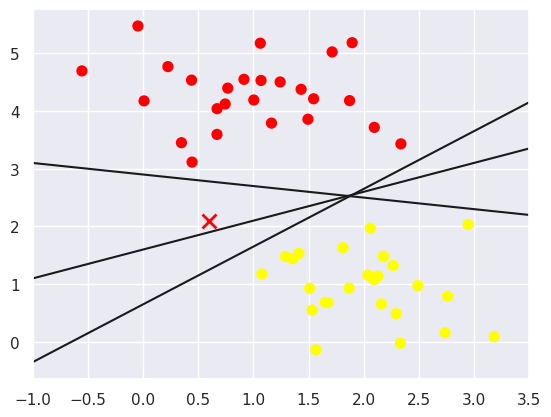

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

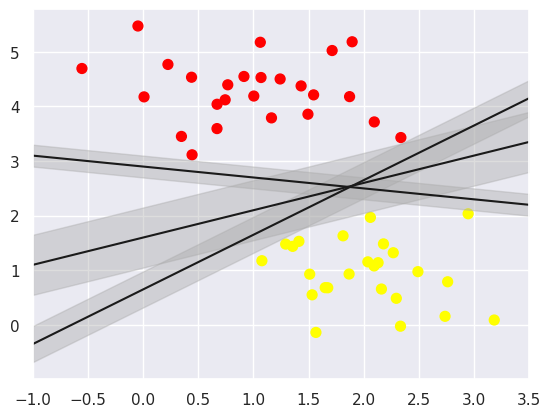

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

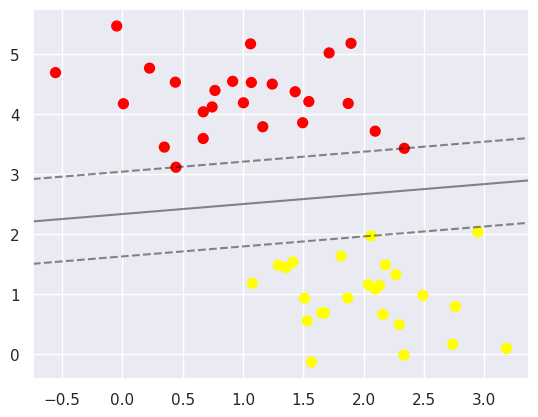

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [ ]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

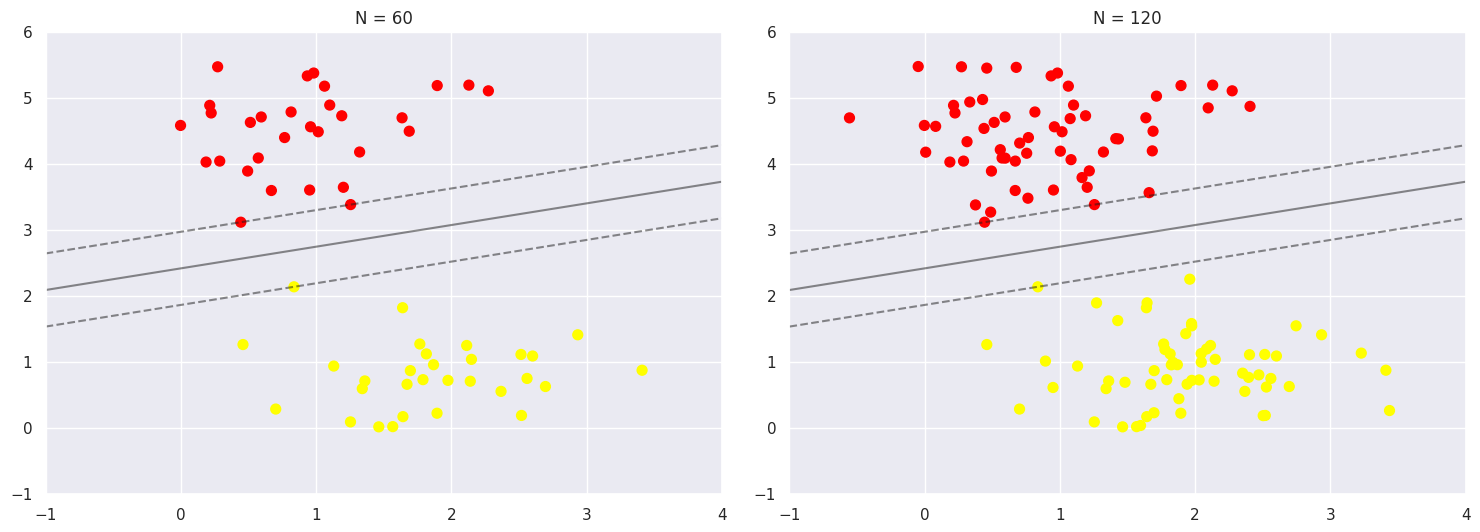

In [ ]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [ ]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions of [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).
There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

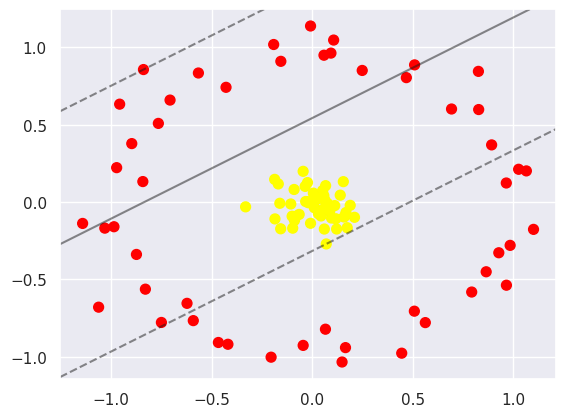

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb), and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [ ]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.
In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [ ]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

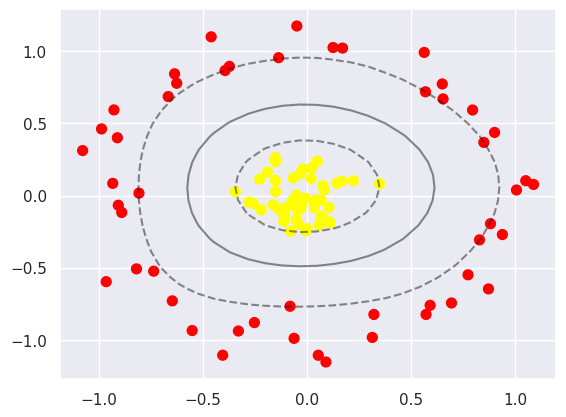

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

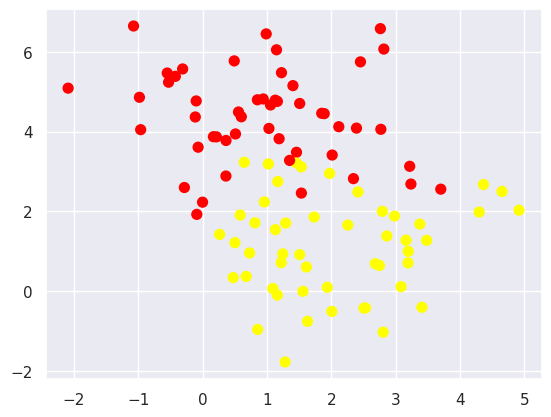

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

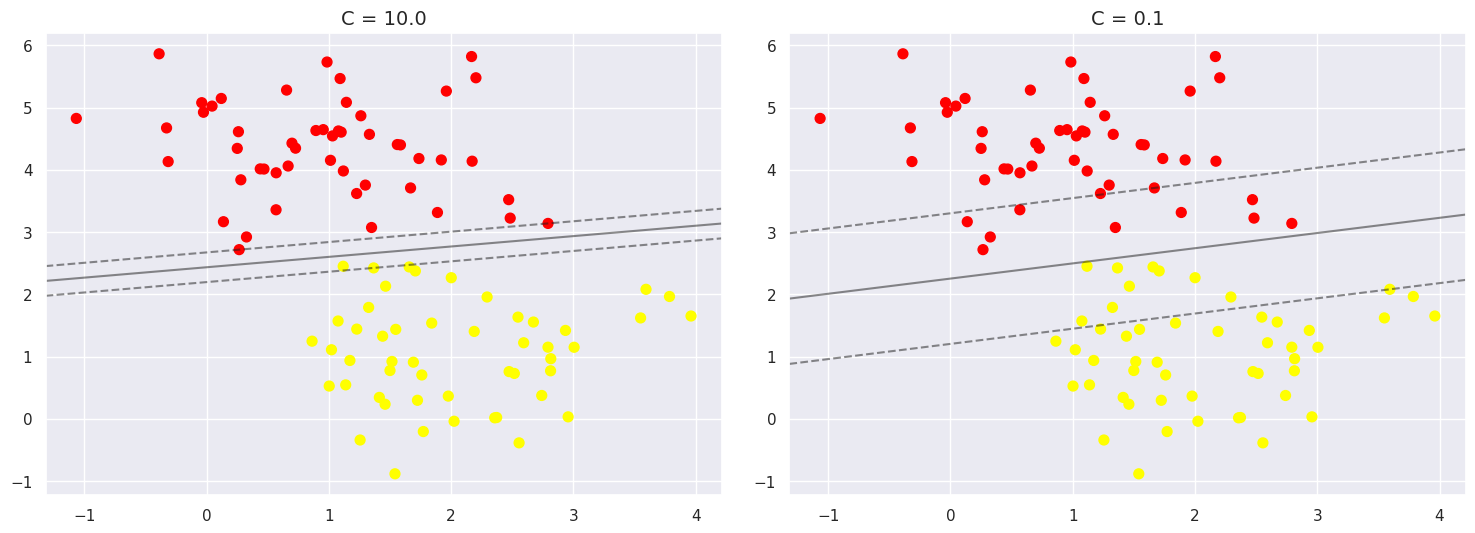

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)).

##SVM: Maximum margin separating hyperplane

Plot the maximum margin separating hyperplane within a two-class separable dataset using a Support Vector Machine classifier with linear kernel.



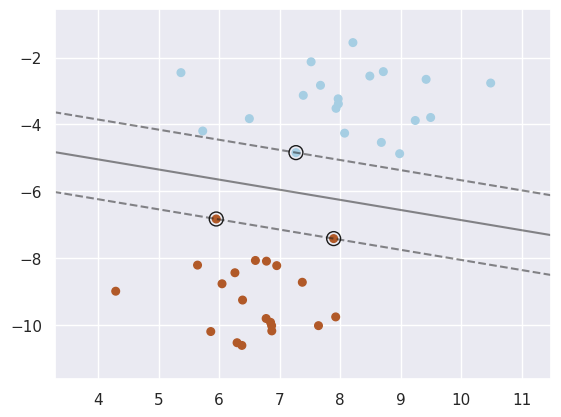

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.show()

## Example: Face Recognition

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

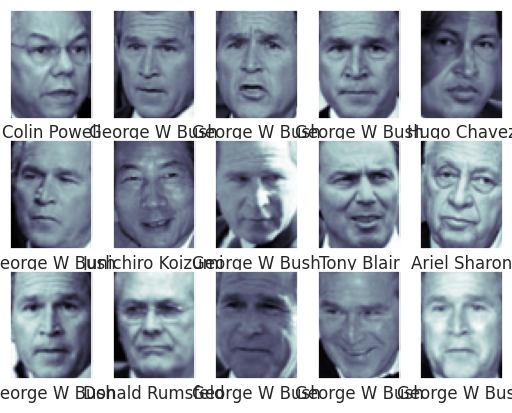

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42, svd_solver='randomized')
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 2min 7s, sys: 236 ms, total: 2min 7s
Wall time: 1min 15s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

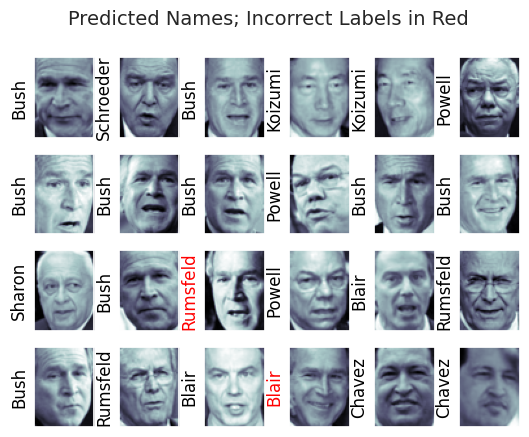

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

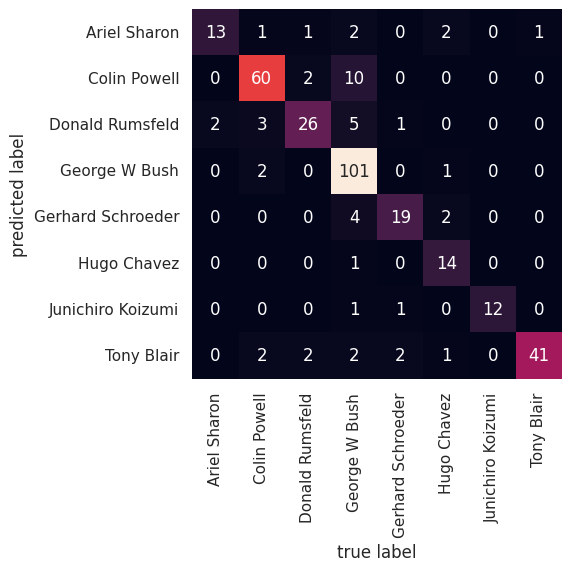

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

--------------------------------------------------------

###SVM Margin Example

The plots below illustrate the effect the parameter C has on the separation line. A large value of C basically tells our model that we do not have that much faith in our data’s distribution, and will only consider points close to line of separation.

A small value of C includes more/all the observations, allowing the margins to be calculated using all the data in the area.


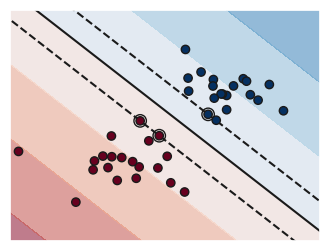

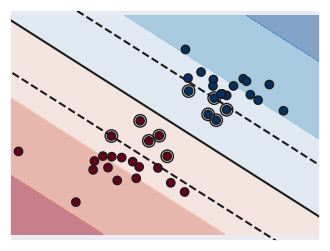

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm

# we create 40 separable points
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# figure number
fignum = 1

# fit the model
for name, penalty in (("unreg", 1), ("reg", 0.05)):
    clf = svm.SVC(kernel="linear", C=penalty)
    clf.fit(X, Y)

    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors (margin away from hyperplane in direction
    # perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
    # 2-d.
    margin = 1 / np.sqrt(np.sum(clf.coef_**2))
    yy_down = yy - np.sqrt(1 + a**2) * margin
    yy_up = yy + np.sqrt(1 + a**2) * margin

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    plt.plot(xx, yy, "k-")
    plt.plot(xx, yy_down, "k--")
    plt.plot(xx, yy_up, "k--")

    plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=80,
        facecolors="none",
        zorder=10,
        edgecolors="k",
    )
    plt.scatter(
        X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.get_cmap("RdBu"), edgecolors="k"
    )

    plt.axis("tight")
    x_min = -4.8
    x_max = 4.2
    y_min = -6
    y_max = 6

    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Put the result into a contour plot
    plt.contourf(XX, YY, Z, cmap=plt.get_cmap("RdBu"), alpha=0.5, linestyles=["-"])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1

plt.show()

##MULTILABEL CLASSIFICATION


This example simulates a multi-label document classification problem. The dataset is generated randomly based on the following process:

pick the number of labels: n ~ Poisson(n_labels)

n times, choose a class c: c ~ Multinomial(theta)

pick the document length: k ~ Poisson(length)

k times, choose a word: w ~ Multinomial(theta_c)

In the above process, rejection sampling is used to make sure that n is more than 2, and that the document length is never zero. Likewise, we reject classes which have already been chosen. The documents that are assigned to both classes are plotted surrounded by two colored circles.

The classification is performed by projecting to the first two principal components found by PCA and CCA for visualisation purposes, followed by using the OneVsRestClassifier metaclassifier using two SVCs with linear kernels to learn a discriminative model for each class. Note that PCA is used to perform an unsupervised dimensionality reduction, while CCA is used to perform a supervised one.

Note: in the plot, “unlabeled samples” does not mean that we don’t know the labels (as in semi-supervised learning) but that the samples simply do not have a label.

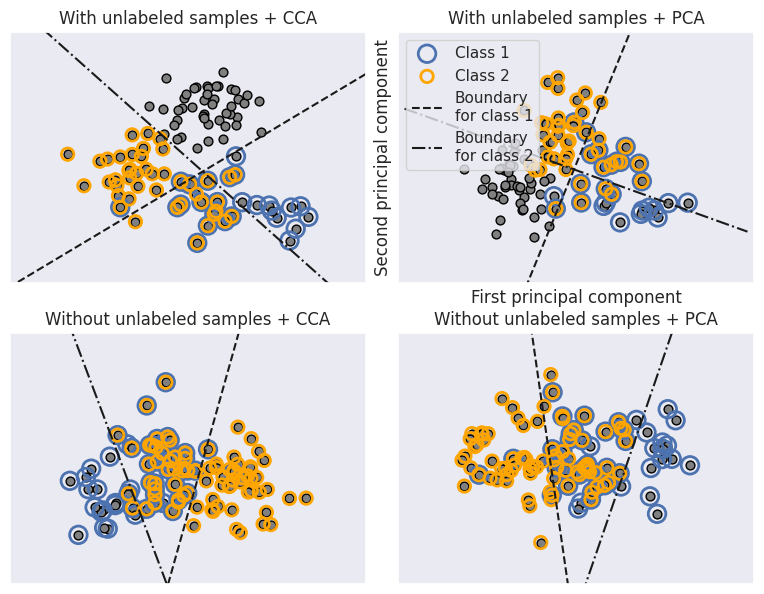

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cross_decomposition import CCA
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel="linear"))
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c="gray", edgecolors=(0, 0, 0))
    plt.scatter(
        X[zero_class, 0],
        X[zero_class, 1],
        s=160,
        edgecolors="b",
        facecolors="none",
        linewidths=2,
        label="Class 1",
    )
    plt.scatter(
        X[one_class, 0],
        X[one_class, 1],
        s=80,
        edgecolors="orange",
        facecolors="none",
        linewidths=2,
        label="Class 2",
    )

    plot_hyperplane(
        classif.estimators_[0], min_x, max_x, "k--", "Boundary\nfor class 1"
    )
    plot_hyperplane(
        classif.estimators_[1], min_x, max_x, "k-.", "Boundary\nfor class 2"
    )
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - 0.5 * max_x, max_x + 0.5 * max_x)
    plt.ylim(min_y - 0.5 * max_y, max_y + 0.5 * max_y)
    if subplot == 2:
        plt.xlabel("First principal component")
        plt.ylabel("Second principal component")
        plt.legend(loc="upper left")


plt.figure(figsize=(8, 6))

X, Y = make_multilabel_classification(
    n_classes=2, n_labels=1, allow_unlabeled=True, random_state=1
)

plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")

X, Y = make_multilabel_classification(
    n_classes=2, n_labels=1, allow_unlabeled=False, random_state=1
)

plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

plt.subplots_adjust(0.04, 0.02, 0.97, 0.94, 0.09, 0.2)
plt.show()

##ROC Curve with Visualization API

First, we load the wine dataset and convert it to a binary classification problem. Then, we train a support vector classifier on a training dataset.

In [ ]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = load_wine(return_X_y=True)
y = y == 2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

SVC(random_state=42)

we plot the ROC curve with a single call to sklearn.metrics.RocCurveDisplay.from_estimator. The returned svc_disp object allows us to continue using the already computed ROC curve for the SVC in future plots.

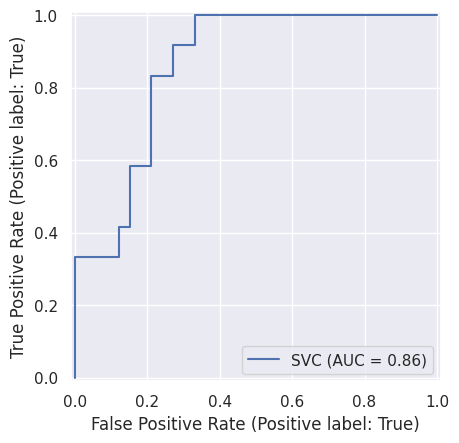

In [ ]:
svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)
plt.show()

##Training a Random Forest and Plotting the ROC Curve

We train a random forest classifier and create a plot comparing it to the SVC ROC curve. Notice how svc_disp uses plot to plot the SVC ROC curve without recomputing the values of the roc curve itself. Furthermore, we pass alpha=0.8 to the plot functions to adjust the alpha values of the curves.

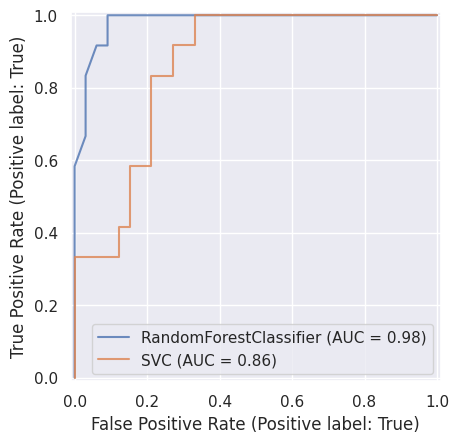

In [ ]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

##Comparison between grid search and successive halving

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.svm import SVC

We first define the parameter space for an SVC estimator, and compute the time required to train a HalvingGridSearchCV instance, as well as a GridSearchCV instance.

In [ ]:
rng = np.random.RandomState(0)
X, y = datasets.make_classification(n_samples=1000, random_state=rng)

gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

clf = SVC(random_state=rng)

tic = time()
gsh = HalvingGridSearchCV(
    estimator=clf, param_grid=param_grid, factor=2, random_state=rng
)
gsh.fit(X, y)
gsh_time = time() - tic

tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic

plot heatmap for both search


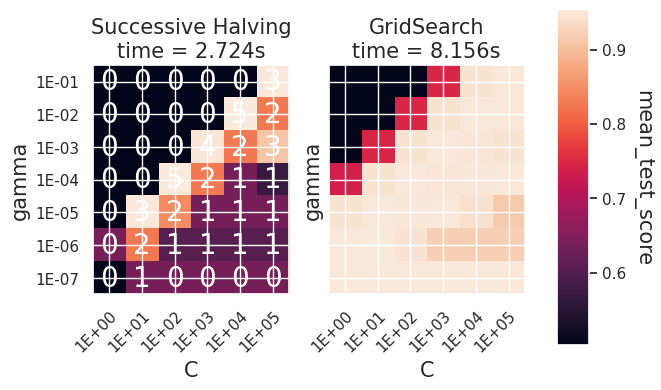

In [ ]:
def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame(gs.cv_results_)
    results[["param_C", "param_gamma"]] = results[["param_C", "param_gamma"]].astype(
        np.float64
    )
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values("iter").pivot_table(
            index="param_gamma",
            columns="param_C",
            values="mean_test_score",
            aggfunc="last",
        )
    else:
        scores_matrix = results.pivot(
            index="param_gamma", columns="param_C", values="mean_test_score"
        )

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in Cs])
    ax.set_xlabel("C", fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in gammas])
    ax.set_ylabel("gamma", fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(
            index="param_gamma", columns="param_C", values="iter", aggfunc="max"
        ).values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(
                    j,
                    i,
                    iterations[i, j],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=20,
                )

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel("mean_test_score", rotation=-90, va="bottom", fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title("Successive Halving\ntime = {:.3f}s".format(gsh_time), fontsize=15)
ax2.set_title("GridSearch\ntime = {:.3f}s".format(gs_time), fontsize=15)

plt.show()

The heatmaps show the mean test score of the parameter combinations for an SVC instance. The HalvingGridSearchCV also shows the iteration at which the combinations where last used. The combinations marked as 0 were only evaluated at the first iteration, while the ones with 5 are the parameter combinations that are considered the best ones.

We can see that the HalvingGridSearchCV class is able to find parameter combinations that are just as accurate as GridSearchCV, in much less time.

Total running time of the script: (0 minutes 8.411 seconds)

##CONFUSION MATRIX

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


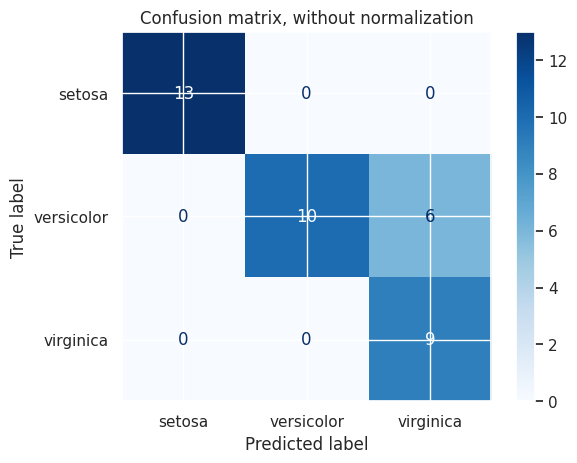

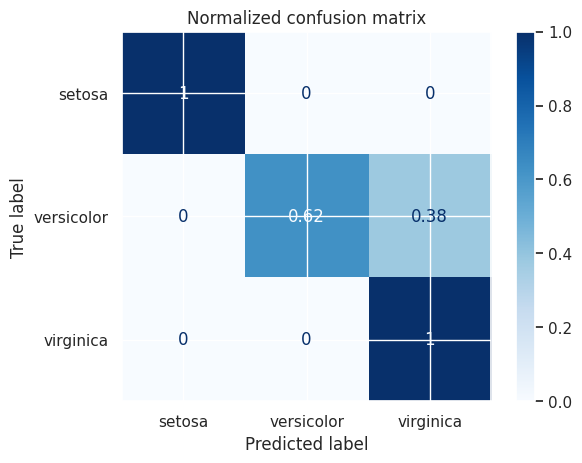

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

##SVM: Weighted samples
Plot decision function of a weighted dataset, where the size of points is proportional to its weight.

The sample weighting rescales the C parameter, which means that the classifier puts more emphasis on getting these points right. The effect might often be subtle. To emphasize the effect here, we particularly weight outliers, making the deformation of the decision boundary very visible.

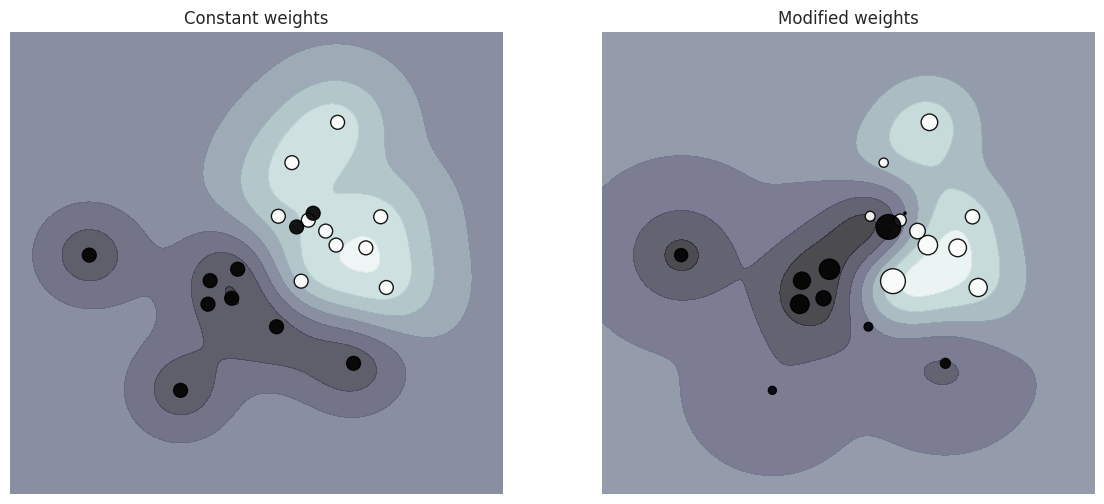

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import svm


def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        s=100 * sample_weight,
        alpha=0.9,
        cmap=plt.cm.bone,
        edgecolors="black",
    )

    axis.axis("off")
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# Fit the models.

# This model does not take into account sample weights.
clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

# This other model takes into account some dedicated sample weights.
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(
    clf_no_weights, sample_weight_constant, axes[0], "Constant weights"
)
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1], "Modified weights")

plt.show()

##SVM: Separating hyperplane for unbalanced classes
Find the optimal separating hyperplane using an SVC for classes that are unbalanced.

We first find the separating plane with a plain SVC and then plot (dashed) the separating hyperplane with automatically correction for unbalanced classes.

Note

This example will also work by replacing SVC(kernel="linear") with SGDClassifier(loss="hinge"). Setting the loss parameter of the SGDClassifier equal to hinge will yield behaviour such as that of a SVC with a linear kernel.

For example try instead of the SVC:

clf = SGDClassifier(n_iter=100, alpha=0.01)

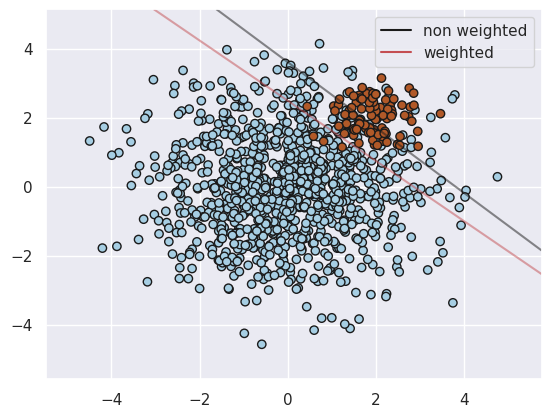

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

# we create two clusters of random points
n_samples_1 = 1000
n_samples_2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(
    n_samples=[n_samples_1, n_samples_2],
    centers=centers,
    cluster_std=clusters_std,
    random_state=0,
    shuffle=False,
)

# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="linear", C=1.0)
clf.fit(X, y)

# fit the model and get the separating hyperplane using weighted classes
wclf = svm.SVC(kernel="linear", class_weight={1: 10})
wclf.fit(X, y)

# plot the samples
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")

# plot the decision functions for both classifiers
ax = plt.gca()
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

# plot decision boundary and margins for weighted classes
wdisp = DecisionBoundaryDisplay.from_estimator(
    wclf,
    X,
    plot_method="contour",
    colors="r",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
    ax=ax,
)

plt.legend(
    [
        mlines.Line2D([], [], color="k", label="non weighted"),
        mlines.Line2D([], [], color="r", label="weighted"),
    ],
    ["non weighted", "weighted"],
    loc="upper right",
)
plt.show()

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

<!--NAVIGATION-->
< [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) | [Contents](Index.ipynb) | [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
